# 0.0 IoT Planning

## Input

**1.** Problem Statement

Customer Personality Analysis is a detailed analysis of a company’s ideal customers. It helps a business to better understand its customers and makes it easier for them to modify products according to the specific needs, behaviors and concerns of different types of customers.

Customer personality analysis helps a business to modify its product based on its target customers from different types of customer segments. For example, instead of spending money to market a new product to every customer in the company’s database, a company can analyze which customer segment is most likely to buy the product and then market the product only on that particular segment.

**2.** Dataset

Information about customer's of a particularly store. 

## Output

**1.** List of customers is specific cluster and cluster specifications.

**2.** Report with business questions anwsers:
- Who are the people eligible to participate in the Insiders program?
- How many customers will be part of each group?
- What are the main characteristics of customers in each group?
- What percentage of revenue contribution comes from Insiders?
- What are the group's revenue expectation for the coming months?
- What are the conditions for a person to be eligible for Insiders?
- What are the conditions for a person to be removed from Insiders?
- What is the guarantee that the Insiders program is better than the rest of the base?
- What actions can marketing time take to increase revenue?

## Tasks

- O que será considerado para definir os 'clientes mais valiosos'? 
    - Faturamento
    - Alto ticket médio
    - Alto LTV
    - Baixa recência
    - Alto basket size
    - Baixa probabilidade de churn
    - Visualização de campanhas
    - Engajamento em campanhas
    
    
- Caracteristicas em comum dos clientes em um cluster
    - idade
    - localização
    - income
    - familia
    - compras
    - engajamento de campanhas
    
    
- Média de valor gasto e número de compras por cluster

# 1.0 Imports

In [1]:
import pandas  as pd
import numpy   as np
import seaborn as sns
import umap.umap_ as umap


from matplotlib          import pyplot as plt
from pycaret.regression  import *
from sklearn             import cluster as c
from sklearn             import metrics as m
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

## 0.1 Load Data 

In [2]:
df_raw = pd.read_csv('data/marketing_campaign.csv', header=0, sep='\t') 

## 0.2 Data Dictionary

Attributes

**People**
- ID: Customer's unique identifier
- Year_Birth: Customer's birth year
- Education: Customer's education level
- Marital_Status: Customer's marital status
- Income: Customer's yearly household income
- Kidhome: Number of children in customer's household
- Teenhome: Number of teenagers in customer's household
- Dt_Customer: Date of customer's enrollment with the company
- Recency: Number of days since customer's last purchase
- Complain: 1 if the customer complained in the last 2 years, 0 otherwise

**Products**
- MntWines: Amount spent on wine in last 2 years
- MntFruits: Amount spent on fruits in last 2 years
- MntMeatProducts: Amount spent on meat in last 2 years
- MntFishProducts: Amount spent on fish in last 2 years
- MntSweetProducts: Amount spent on sweets in last 2 years
- MntGoldProds: Amount spent on gold in last 2 years

**Promotion**
- NumDealsPurchases: Number of purchases made with a discount
- AcceptedCmp1: 1 if customer accepted the offer in the 1st campaign, 0 otherwise
- AcceptedCmp2: 1 if customer accepted the offer in the 2nd campaign, 0 otherwise
- AcceptedCmp3: 1 if customer accepted the offer in the 3rd campaign, 0 otherwise
- AcceptedCmp4: 1 if customer accepted the offer in the 4th campaign, 0 otherwise
- AcceptedCmp5: 1 if customer accepted the offer in the 5th campaign, 0 otherwise
- Response: 1 if customer accepted the offer in the last campaign, 0 otherwise

**Place**
- NumWebPurchases: Number of purchases made through the company’s website
- NumCatalogPurchases: Number of purchases made using a catalogue
- NumStorePurchases: Number of purchases made directly in stores
- NumWebVisitsMonth: Number of visits to company’s website in the last month

# 1.0 Data Description

In [3]:
df1 = df_raw.copy()

## 1.1 Data Dimensions

In [4]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 2240
Number of columns: 29


## 1.2 Rename Columns

In [5]:
df1.columns = df1.columns.str.lower()

## 1.3 Data Types

In [6]:
df1.dtypes

id                       int64
year_birth               int64
education               object
marital_status          object
income                 float64
kidhome                  int64
teenhome                 int64
dt_customer             object
recency                  int64
mntwines                 int64
mntfruits                int64
mntmeatproducts          int64
mntfishproducts          int64
mntsweetproducts         int64
mntgoldprods             int64
numdealspurchases        int64
numwebpurchases          int64
numcatalogpurchases      int64
numstorepurchases        int64
numwebvisitsmonth        int64
acceptedcmp3             int64
acceptedcmp4             int64
acceptedcmp5             int64
acceptedcmp1             int64
acceptedcmp2             int64
complain                 int64
z_costcontact            int64
z_revenue                int64
response                 int64
dtype: object

## 1.4 Check N/A

In [7]:
df1.isna().sum()

id                      0
year_birth              0
education               0
marital_status          0
income                 24
kidhome                 0
teenhome                0
dt_customer             0
recency                 0
mntwines                0
mntfruits               0
mntmeatproducts         0
mntfishproducts         0
mntsweetproducts        0
mntgoldprods            0
numdealspurchases       0
numwebpurchases         0
numcatalogpurchases     0
numstorepurchases       0
numwebvisitsmonth       0
acceptedcmp3            0
acceptedcmp4            0
acceptedcmp5            0
acceptedcmp1            0
acceptedcmp2            0
complain                0
z_costcontact           0
z_revenue               0
response                0
dtype: int64

## 1.5 Replace N/A

In [8]:
df1 = df1.dropna(subset=['income'])
print('Removed data: {:.2f}'.format(1-(df1.shape[0]/df_raw.shape[0])))

Removed data: 0.01


## 1.6 Change data types

In [9]:
#dt_customer
df1['dt_customer'] = pd.to_datetime(df1['dt_customer'], format='%d-%m-%Y')

## 1.7 Descriptive Statistics

In [10]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [11]:
#central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concat
n = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
n.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [12]:
n

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,0.0,11191.0,11191.0,5588.353339,5458.5,3248.643030,0.040459,-1.189677
1,year_birth,1893.0,1996.0,103.0,1968.820397,1970.0,11.982849,-0.353661,0.734670
2,income,1730.0,666666.0,664936.0,52247.251354,51381.5,25167.396174,6.763487,159.636700
3,kidhome,0.0,2.0,2.0,0.441787,0.0,0.536775,0.635610,-0.791164
4,teenhome,0.0,2.0,2.0,0.505415,0.0,0.544058,0.407553,-0.989619
5,recency,0.0,99.0,99.0,49.012635,49.0,28.941819,0.001648,-1.199777
6,mntwines,0.0,1493.0,1493.0,305.091606,174.5,337.251800,1.170720,0.582741
7,mntfruits,0.0,199.0,199.0,26.356047,8.0,39.784937,2.101658,4.054082
8,mntmeatproducts,0.0,1725.0,1725.0,166.995939,68.0,224.232662,2.025577,5.055477
9,mntfishproducts,0.0,259.0,259.0,37.637635,12.0,54.739727,1.916369,3.076476


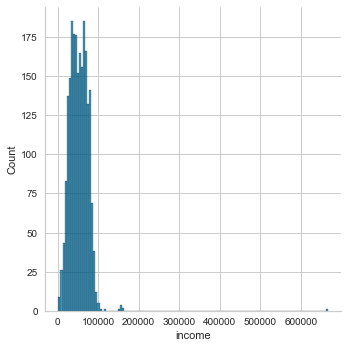

In [13]:
sns.displot(data=num_attributes, x="income");

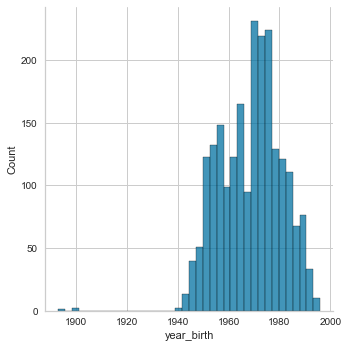

In [14]:
sns.displot(data=num_attributes, x="year_birth");

### 1.7.2 Categorical Attributes

<AxesSubplot:xlabel='education', ylabel='income'>

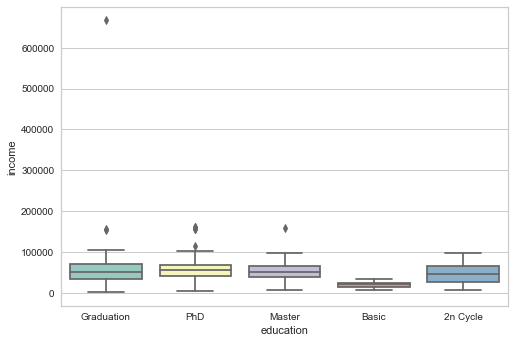

In [15]:
sns.boxplot(x="education", y="income", data=df1, palette="Set3")

<AxesSubplot:xlabel='marital_status', ylabel='income'>

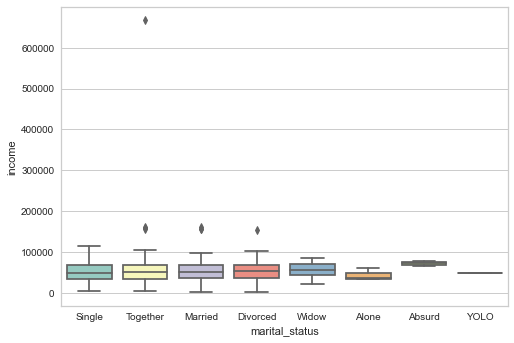

In [16]:
sns.boxplot(x="marital_status", y="income", data=df1, palette="Set3")

# 2.0 Data Filtering

In [17]:
df2 = df1.copy()

In [18]:
#drop z_ columns
df2 = df2.drop(columns=['z_costcontact', 'z_revenue'])

# 3.0 Feature Engineering

In [19]:
df3 = df2.copy()

In [20]:
#total amount spend
df3['mnttotal'] = df3['mntwines'] + df3['mntfruits'] + df3['mntmeatproducts'] + df3['mntfishproducts'] + df3['mntsweetproducts'] + df3['mntgoldprods']

#total number of purchases
df3['numtotalpurchases'] = df3['numwebpurchases'] + df3['numcatalogpurchases'] + df3['numstorepurchases'] + df3['numwebvisitsmonth']

In [21]:
df3.head()

,id,year_birth,education,marital_status,income,kidhome,teenhome,dt_customer,recency,mntwines,mntfruits,mntmeatproducts,mntfishproducts,mntsweetproducts,mntgoldprods,numdealspurchases,numwebpurchases,numcatalogpurchases,numstorepurchases,numwebvisitsmonth,acceptedcmp3,acceptedcmp4,acceptedcmp5,acceptedcmp1,acceptedcmp2,complain,response,mnttotal,numtotalpurchases
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,1617,29
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,27,9
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,776,24
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,53,12
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,422,19


# 5.0 EDA (Exploratory Data Analysis)

# 6.0 Data Preparation

# 7.0 Feature Selection

# 8.0 Hyperparameter Fine-Tuning

In [22]:
X = df4.drop(columns=['id', 'education', 'marital_status', 'dt_customer', 'mntwines','mntfruits', 'mntmeatproducts', 'mntfishproducts', 'mntsweetproducts', 'mntgoldprods', 'numwebpurchases',
                       'numcatalogpurchases', 'numstorepurchases', 'numwebvisitsmonth'])

NameError: name 'df4' is not defined

In [ ]:
clusters = [2, 3, 4, 5, 6]

## 8.1 Within-cluster Sum of Square (WSS) 

WSS = o quão unidos/juntos os pontos de um mesmo cluster estão.

In [ ]:
wss = []
for k in clusters:
    #model definition
    kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)
    
    #model training
    kmeans.fit(X)
    
    #validation
    wss.append(kmeans.inertia_)

#plot wss - Elbow Method
plt.plot(clusters, wss, linestyle='--', marker='o', color='b')
plt.xlabel('K');
plt.ylabel('WSS');
plt.title('WSS x K');

In [ ]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, timing=False)
kmeans.fit(X)
kmeans.show()

## 8.2 Silhouette Score

SS = o quão distante um cluster está do outro.

In [ ]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, metric='silhouette', timing=False)
kmeans.fit(X)
kmeans.show()

# 9.0 Model Training

In [ ]:
#model definition
kmeans = c.KMeans(init='random', n_clusters=2, n_init=10, max_iter=300, random_state=42)
    
#model training
kmeans.fit(X)
    
#model predict
labels = kmeans.predict(X)

## 9.1 Cluster Validation

In [ ]:
#WSS (within-cluster sum of square)
print('WSS values: {}'.format(kmeans.inertia_))

#SS (silhouette score)
print('SS value: {}'.format(m.silhouette_score(X, labels, metric='euclidean')))

# 10.0 Cluster Analysis

In [ ]:
df10 = X.copy()
df10['cluster'] = labels
df10.head()

## 10.1 Visual Inspection

In [ ]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize()

## 10.2 2D Plot 

In [ ]:
#sns.pairplot(df10, hue='cluster')

## 10.3 UMAP 

In [ ]:
reducer = umap.UMAP(n_neighbors=30, random_state=42)
embedding = reducer.fit_transform(X)
df_viz = df10.copy()

#embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

#plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y',
               hue='cluster',
               palette=sns.color_palette('hls', n_colors=len(df_viz['cluster'].unique())),
               data=df_viz)

# 11.0 Cluster Exploratory Data Analysis

In [ ]:
df11 = df10.copy()
df11['id'] = df4['id']

In [ ]:
df11.head()

In [ ]:
#number of customers
df_cluster = df11[['id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customers'] = 100*(df_cluster['id']/df_cluster['id'].sum())

#avg_income
df_avg_income = df11[['income', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_income, how='inner', on='cluster')

#avg_recency
df_avg_recency = df11[['recency', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency, how='inner', on='cluster')

#avg_total_spend
df_avg_spend = df11[['mnttotal', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_spend, how='inner', on='cluster')

#avg_total_purchases
df_avg_purchases = df11[['numtotalpurchases', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_purchases, how='inner', on='cluster')

#avg_kids
df_avg_kids = df11[['kidhome', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_kids, how='inner', on='cluster')

#avg_teen
df_avg_teen = df11[['teenhome', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_teen, how='inner', on='cluster')

In [ ]:
df_cluster.head()

# 12.0 Deploy